# mxnet 图像识别教程


这里以 TinyMind 《汉字书法识别》比赛数据为例，展示使用 mxnet 进行图像数据分类模型训练的整个流程。

数据地址请参考:
https://www.tinymind.cn/competitions/41#property_23

或到这里下载：
自由练习赛数据下载地址：
训练集：链接: https://pan.baidu.com/s/1UxvN7nVpa0cuY1A-0B8gjg 密码: aujd

测试集: https://pan.baidu.com/s/1tzMYlrNY4XeMadipLCPzTw 密码: 4y9k

# 数据探索
请参考官方的数据说明

# 数据处理

竞赛中只有训练集 train 数据有准确的标签，因此这里只使用 train 数据即可，实际应用中，阶段 1、2 的榜单都需要使用。

## 数据下载

下载数据之后进行解压，得到 train 文件夹，里面有 100 个文件夹，每个文件夹名字即是各个汉字的标签。类似的数据集结构经常在分类任务中见到。可以使用下述命令验证一下每个文件夹下面文件的数量，看数据集是否符合竞赛数据描述：
```sh
for l in $(ls); do echo $l $(ls $l|wc -l); done
```

## 划分数据集

因为这里只使用了 train 集，因此我们需要对已有数据集进行划分，供模型训练的时候做验证使用，也就是 validation 集的构建。
> 一般认为，train 用来训练模型，validation 用来对模型进行验证以及超参数（ hyper parameter）调整，test 用来做模型的最终验证，我们所谓模型的性能，一般也是指 test 集上模型的性能指标。但是实际项目中，一般只有 train 集，同时没有可靠的 test 集来验证模型，因此一般将 train 集划分出一部分作为 validation，同时将 validation 上的模型性能作为最终模型性能指标。

> 一般情况下，我们不严格区分 validation 和 test。

这里将每个文件夹下面随机50个文件拿出来做 validation。

```sh
export train=train
export val=validation

for d in $(ls $train); do
    mkdir -p $val/$d/
    for f in $(ls train/$d | shuf | head -n 50 ); do
        mv $train/$d/$f $val/$d/;
    done;
done
```

> 需要注意，这里的 validation 只间接通过超参数的调整参与了模型训练。因此有一定的数据浪费。

# 模型训练代码-数据部分
首先导入 mxnet 看一下版本

In [1]:
import mxnet as mx

mx.__version__

'1.6.0'

训练模型的时候，模型内部全部都是数字，没有任何可读性，而且这些数字也需要人为给予一些实际的意义，这里将 100 个汉字作为模型输出数字的文字表述。

需要注意的是，因为模型训练往往是一个循环往复的过程，因此一个稳定的文字标签是很有必要的，这里利用相关 python 代码在首次运行的时候生成了一个标签文件，后续检测到这个标签文件，则直接调用即可。

In [2]:
import os

if os.path.exists("labels.txt"):
    with open("labels.txt") as inf:
        classes = [l.strip() for l in inf]
else:
    classes = os.listdir("worddata/train/")
    with open("labels.txt", "w") as of:
        of.write("\r\n".join(classes))

class_idx = {v: k for k, v in enumerate(classes)}
idx_class = dict(enumerate(classes))

pyTorch里面，classes有自己的组织方式，这里我们想要自定义，要做一下转换。

In [3]:
from PIL import Image

pth_classes = classes[:]
pth_classes.sort()
pth_classes_to_idx = {v: k for k, v in enumerate(pth_classes)}


def transform(data, pth_idx):
    return data, class_idx[pth_classes[pth_idx]]

mxnet 中提供了直接从目录中读取数据并进行训练的 API 这里使用的API如下。

这里使用了两个数据集，分别代表 train、validation。

需要注意的是，由于 数据中，使用的图像数据集，其数值在（0， 255）之间。同时，mxnet 用 opencv 来处理图像的加载，其图像的数据 layout 是（H，W，C），而 mxnet 用来训练的数据需要是（C，H，W）的，因此需要对数据做一些转换。另外，train 数据集做了一定的数据预处理（旋转、明暗度），用于进行数据增广，也做了数据打乱（shuffle），而 validation则不需要做类似的变换。

> ToTensor这个操作会转换数据的 layout，因此要放在最后面。

In [4]:
from multiprocessing import cpu_count

transform_train = mx.gluon.data.vision.transforms.Compose(
    [
        # mx.gluon.data.vision.transforms.RandomRotation((-15, 15), zoom_out=True),
        # 带随机旋转的版本还没发布
        mx.gluon.data.vision.transforms.Resize((128, 128)),
        mx.gluon.data.vision.transforms.RandomColorJitter(brightness=0.5),
        mx.gluon.data.vision.transforms.ToTensor(),
    ]
)
transform_val = mx.gluon.data.vision.transforms.Compose(
    [
        mx.gluon.data.vision.transforms.Resize((128, 128)),
        mx.gluon.data.vision.transforms.ToTensor(),
    ]
)


img_gen_train = mx.gluon.data.vision.datasets.ImageFolderDataset(
    "worddata/train/", transform=transform, flag=0
)


img_gen_val = mx.gluon.data.vision.datasets.ImageFolderDataset(
    "worddata/validation/", transform=transform, flag=0
)

batch_size = 32

img_train = mx.gluon.data.DataLoader(
    img_gen_train.transform_first(transform_train),
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count(),
)
img_val = mx.gluon.data.DataLoader(
    img_gen_val.transform_first(transform_val),
    batch_size=batch_size,
    num_workers=cpu_count(),
)

到这里，这两个数据集就可以使用了，正式模型训练之前，我们可以先来看看这个数据集是怎么读取数据的，读取出来的数据又是设么样子的。

In [5]:
for imgs, labels in img_train:
    # img_train 只部分满足 generator 的语法，不能用 next 来获取数据
    break
imgs.shape, labels.shape

((32, 1, 128, 128), (32,))

可以看到数据是（batch, channel, height, width, height）, 因为这里是灰度图像，因此 channel 是 1。

> 需要注意，pyTorch、mxnet使用的数据 layout 与Tensorflow 不同，因此数据也有一些不同的处理方式。

把图片打印出来看看，看看数据和标签之间是否匹配


'利'

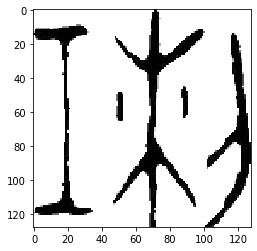

In [6]:
import numpy as np
from matplotlib import pyplot as plt

plt.imshow(imgs.asnumpy()[0, 0, :, :], cmap="gray")
classes[labels.asnumpy()[0]]

# 模型训练代码-模型构建

mxnet 中使用动态图来构建模型，模型构建比较简单。这里演示的是使用 class 的方式构建模型，对于简单模型，还可以直接使用 Sequential 进行构建。

这里的复杂模型也是用 Sequential 的简单模型进行的叠加。

> 这里构建的是VGG模型，关于VGG模型的更多细节请参考 1409.1556。

In [7]:
class MyModel(mx.gluon.nn.HybridBlock):
    def __init__(self):
        super(MyModel, self).__init__()
        # 模型有两个主要部分，特征提取层和分类器

        # 这里是特征提取层
        self.feature = mx.gluon.nn.HybridSequential()

        self.feature.add(self.conv(64))
        self.feature.add(self.conv(64, add_pooling=True))

        self.feature.add(self.conv(128))
        self.feature.add(self.conv(128, add_pooling=True))

        self.feature.add(self.conv(256))
        self.feature.add(self.conv(256))
        self.feature.add(self.conv(256, add_pooling=True))
        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512, add_pooling=True))

        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512, add_pooling=True))
        self.feature.add(mx.gluon.nn.GlobalAvgPool2D())
        self.feature.add(mx.gluon.nn.Flatten())

        self.feature.add(mx.gluon.nn.Dense(4096, activation="relu"))
        self.feature.add(mx.gluon.nn.BatchNorm())

        self.feature.add(mx.gluon.nn.Dense(4096, activation="relu"))
        self.feature.add(mx.gluon.nn.BatchNorm())

        self.feature.add(mx.gluon.nn.Dropout(0.5))
        # 这个简单的机构是分类器
        self.pred = mx.gluon.nn.Dense(100)

    def conv(self, filters, add_pooling=False):
        # 模型大量使用重复模块构建，
        # 这里将重复模块提取出来，简化模型构建过程
        model = mx.gluon.nn.HybridSequential()
        model.add(mx.gluon.nn.Conv2D(filters, 3, padding=1, activation="relu"))
        model.add(mx.gluon.nn.BatchNorm())

        if add_pooling:
            model.add(mx.gluon.nn.MaxPool2D(strides=2))
        return model

    def hybrid_forward(self, F, x):
        # call 用来定义模型各个结构之间的运算关系

        x = self.feature(x)
        return self.pred(x)

上面使用的是 gluon api 相比于 gluon api，mxnet 还有纯符号和纯静态图的方式，但是不如 gluon api 方便，就像 keras 之于 Tensorflow， gluon api 也是 mxnet 社区主推的方式。

> HybridBlock 这种带 Hybrid 前缀的模块，底层可以编译成静态图，速度快一些，可以尽量多用一下。不带Hybrid 前缀的模块使用起来不太一样。

实例化一个模型看看：

In [8]:
ctx = mx.gpu(0)
model = MyModel()
model.initialize(ctx=ctx, init=mx.initializer.Xavier())
model.hybridize()

model

MyModel(
  (feature): HybridSequential(
    (0): HybridSequential(
      (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    )
    (1): HybridSequential(
      (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
      (2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    )
    (2): HybridSequential(
      (0): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    )
    (3): HybridSequential(
      (0): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1), pa

# 模型训练代码-训练相关部分
要训练模型，我们还需要定义损失，优化器等。

In [9]:
loss_object = mx.gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.gluon.Trainer(model.collect_params(), mx.optimizer.Adam())  # 优化器有些参数可以设置

train_accuracy = mx.metric.Accuracy()
val_accuracy = mx.metric.Accuracy()

In [10]:
import time  # 模型训练的过程中手动追踪一下模型的训练速度

因为模型整个训练过程一般是一个循环往复的过程，所以经常性的保存重启模型训练中间过程是有必要的。
这里我们一个ckpt保存了两份，便于中断模型的重新训练。

In [11]:
import os

if os.path.exists("model.params"):
    # 检查 checkpoint 是否存在
    # 如果存在，则加载 checkpoint
    model.load_parameters("model.params")

    # 这里是一个比较生硬的方式，其实还可以观察之前训练的过程，
    # 手动选择准确率最高的某次 checkpoint 进行加载。
    print("model lodaded")

In [12]:
EPOCHS = 20
for epoch in range(EPOCHS):

    train_loss = 0
    train_samples = 0
    train_accuracy.reset()
    val_accuracy.reset()

    val_loss = 0
    val_samples = 0

    start = time.time()
    for imgs, labels in img_train:
        imgs = imgs.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with mx.autograd.record():
            preds = model(imgs)
            loss = loss_object(preds, labels)
        loss.backward()

        optimizer.step(batch_size)

        train_loss += loss.sum().asscalar()
        train_accuracy.update(labels, preds)

        train_samples += imgs.shape[0]
        mx.nd.waitall()

    train_samples_per_second = train_samples / (time.time() - start)

    start = time.time()
    for imgs, labels in img_val:
        imgs = imgs.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        preds = model(imgs)
        loss = loss_object(preds, labels)

        val_loss += loss.sum().asscalar()
        val_accuracy.update(labels, preds)

        val_samples += imgs.shape[0]
        mx.nd.waitall()

    val_samples_per_second = val_samples / (time.time() - start)

    print(
        "Epoch {} Loss {}, Acc {}, Val Loss {}, Val Acc {}".format(
            epoch,
            train_loss / train_samples,
            train_accuracy.get()[1] * 100,
            val_loss / val_samples,
            val_accuracy.get()[1] * 100,
        )
    )
    print(
        "Speed train {}imgs/s val {}imgs/s".format(
            train_samples_per_second, val_samples_per_second
        )
    )

    model.save_parameters("model.params")
    model.save_parameters("model-{:04d}.params".format(epoch))

    # 每个 epoch 保存一下模型，需要注意每次
    # 保存要用一个不同的名字，不然会导致覆盖，
    # 同时还要关注一下磁盘空间占用，防止太多
    # chekcpoint 占满磁盘空间导致错误。

Epoch 0 Loss 6.9573759181431365, Acc 1.042857142857143, Val Loss 15.420175067138672, Val Acc 1.68
Speed train 334.933801136163imgs/s val 791.7329888468499imgs/s
Epoch 1 Loss 6.7644785858154295, Acc 1.1114285714285714, Val Loss 21.39283991394043, Val Acc 0.9400000000000001
Speed train 344.24428987859835imgs/s val 1005.8295516339732imgs/s
Epoch 2 Loss 6.427109525844029, Acc 1.1142857142857143, Val Loss 1441.4082737342835, Val Acc 1.46
Speed train 350.2307806800212imgs/s val 1025.2414031403846imgs/s
Epoch 3 Loss 5.979110830688477, Acc 1.1114285714285714, Val Loss 402112.5587174507, Val Acc 1.08
Speed train 343.90973606373484imgs/s val 1007.538116122915imgs/s
Epoch 4 Loss 5.7047360944475445, Acc 1.0114285714285716, Val Loss 28.884018599700926, Val Acc 1.16
Speed train 346.9289205956802imgs/s val 1042.5033657692259imgs/s
Epoch 5 Loss 5.429534565952846, Acc 1.1828571428571428, Val Loss 25.10572717514038, Val Acc 1.06
Speed train 346.55915907021785imgs/s val 1042.9843522905003imgs/s
Epoch 6 L

# 一些技巧

因为这里定义的模型比较大，同时训练的数据也比较多，每个 epoch 用时较长，因此，如果代码有 bug 的话，经过一次 epoch 再去 debug 效率比较低。

这种情况下，我们使用的数据生成过程又是自己手动指定数据数量的，因此可以尝试缩减模型规模，定义小一些的数据集来快速验证代码。在这个例子里，我们可以通过注释模型中的卷积和全连接层的代码来缩减模型尺寸，通过修改训练循环里面的数据数量来缩减数据数量。

# 训练的速度很慢
一开始训练速度比较慢，因为 mxnet 默认初始化方式是 uniform。

这里改成了跟 tf 一样的 xavier （tf里面叫做 glorot_uniform）之后训练速度还是比较慢，要 10 个 epoch才能看到收敛。而且 TF 里面 20epochs 能达到 90% 的准确率，这里菜 76%，应该是哪里有什么问题，我再看看怎么解决。